<a href="https://colab.research.google.com/github/SeyedJalaleddinMousavirad/ConvelutionalNeuralNetworks/blob/main/PyTorch_CNN_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
# from datetime import datetime

# root is where to download the data to
# train = true, return train dataset
# transform does some useful preprocessing
# download the data
# train dataset
train_dataset = torchvision.datasets.FashionMNIST(root='.', train=True, transform=transforms.ToTensor(), download=True)
# test dataset
test_dataset = torchvision.datasets.FashionMNIST(root='.', train=False, transform=transforms.ToTensor(), download=True)




  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [2]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [3]:
train_dataset.data.min()

tensor(0, dtype=torch.uint8)

In [5]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [6]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [10]:
len(set(train_dataset.targets.numpy()))

10

In [11]:
# number of classes
K = len(set(train_dataset.targets.numpy()))
print("Number of classes: ", K)


# Define the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()

    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
        # in_channels=1 because MNIST dataset includes greyscale image
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
        nn.ReLU()
    )
    self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128 * 2 * 2, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, K)
    )
    #We can generate a model also by the following method
    self.new_model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(128 * 2 * 2, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, K)
    )

  def forward(self, X):
    out = self.conv_layers(X) # Convolution layer
    out = out.view(out.size(0), -1) # Flatten layer (-1 means auto calculate)
    out = self.dense_layers(out) # Dense layer
    return out

# Instantiate the model
model = CNN(K)

Number of classes:  10


In [14]:
device = torch.device("cude:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # we use this because we have multiple categories
optimizer = torch.optim.Adam(model.parameters()) # we use Adam jus cuz

# Data load
# Useful because it automatically generates batches in the training loop
# and takes care of the shuffling

batch_size = 128
# shuffle training data, but not test data
# we dont want correlations between the data
# no need to shuffle test data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

cpu


In [15]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
from timeit import default_timer as timer
import sys
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):

  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    start = timer()
    train_loss = []
    for inputs, targets in train_loader:
      # Move data to GPU if device is GPU
      inputs, targets = inputs.to(device), targets.to(device)
      
      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and Optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
 
    
    # Get the train loss and test loss
    train_loss = np.mean(train_loss)  # a little misleading

    # test loss
    # same as train loop, except for backward and optimizer steps

    test_loss = []
    for inputs, targets in test_loader:
      # inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())

    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    end = timer()
    duration = "{:.2f}".format(end - start)
    print('Duration: ' + str(duration)) # Time in seconds, e.g. 5.38091952400282
  return train_losses, test_losses




Epoch 1/25, Train Loss: 0.6752, Test Loss: 0.5242
Duration: 41.24
Epoch 2/25, Train Loss: 0.4454, Test Loss: 0.4452
Duration: 35.75
Epoch 3/25, Train Loss: 0.3860, Test Loss: 0.3951
Duration: 34.56
Epoch 4/25, Train Loss: 0.3444, Test Loss: 0.3931
Duration: 34.85
Epoch 5/25, Train Loss: 0.3214, Test Loss: 0.3590
Duration: 34.90
Epoch 6/25, Train Loss: 0.2973, Test Loss: 0.3347
Duration: 33.29
Epoch 7/25, Train Loss: 0.2787, Test Loss: 0.3364
Duration: 34.29
Epoch 8/25, Train Loss: 0.2614, Test Loss: 0.3219
Duration: 34.86
Epoch 9/25, Train Loss: 0.2481, Test Loss: 0.3269
Duration: 33.41
Epoch 10/25, Train Loss: 0.2362, Test Loss: 0.3179
Duration: 34.04
Epoch 11/25, Train Loss: 0.2239, Test Loss: 0.3234
Duration: 33.84
Epoch 12/25, Train Loss: 0.2105, Test Loss: 0.3193
Duration: 33.54
Epoch 13/25, Train Loss: 0.1999, Test Loss: 0.3159
Duration: 33.70
Epoch 14/25, Train Loss: 0.1907, Test Loss: 0.3160
Duration: 33.25
Epoch 15/25, Train Loss: 0.1814, Test Loss: 0.3180
Duration: 34.39
Epoc

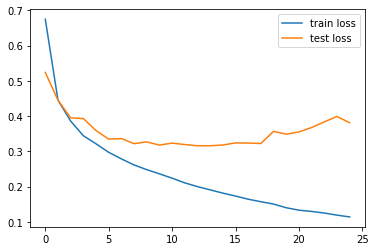

In [16]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=25)

# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [17]:
# Calculate the accuracy

# train accuracy
n_correct = 0
n_total = 0
for inputs, targets in train_loader:
  # move data to GPU
  # inputs, targets = inputs.to(device), targets.to(device)

  # forward pass
  outputs = model(inputs)

  # get the prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

# test accuracy
n_correct = 0
n_total = 0
for inputs, targets in test_loader:
  # move data to GPU
  # inputs, targets = inputs.to(device), targets.to(device)

  # forward pass
  outputs = model(inputs)

  # get the prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total


print(f'Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

Train Accuracy: 0.9656, Test Accuracy: 0.8945


Confusion matrix, without normalization
[[864   0  21  22   3   0  82   0   8   0]
 [  0 977   0  16   3   1   2   0   1   0]
 [ 19   2 847  10  48   0  70   0   4   0]
 [ 13   8  18 896  26   1  35   0   3   0]
 [  1   1  53  29 853   0  58   0   5   0]
 [  0   0   0   1   0 968   0  16   1  14]
 [ 99   0  61  26  93   0 706   0  15   0]
 [  0   0   0   0   0  21   0 945   0  34]
 [  1   0   2   4   1   3   3   3 983   0]
 [  1   0   0   0   0   5   0  28   1 965]]


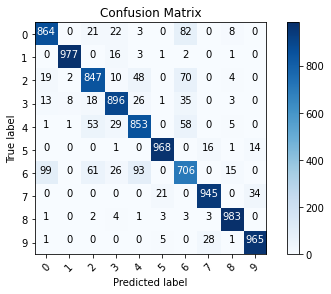

In [18]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
  """
  The function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'
  """

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")

  else:
    print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'

  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# get all predictions in an array and plot confusion matrix
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  # inputs, targets = inputs.to(device), targets.to(device)

  # forward pass
  outputs = model(inputs)

  # get the prediction
  #torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

Text(0.5, 1.0, 'True label: 2 Predicted: 6')

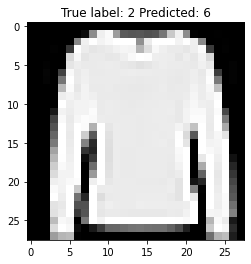

In [19]:
# show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], int(p_test[i])))